Problem 1

Using device: cuda
Seq Length: 10 | Epoch: 1 | Train Loss: 2.9611 | Train Acc: 0.1908 | Val Loss: 2.7074 | Val Acc: 0.2479
Seq Length: 10 | Epoch: 2 | Train Loss: 2.4653 | Train Acc: 0.2909 | Val Loss: 2.6024 | Val Acc: 0.2689
Seq Length: 10 | Epoch: 3 | Train Loss: 2.3180 | Train Acc: 0.3012 | Val Loss: 2.4895 | Val Acc: 0.3151
Seq Length: 10 | Epoch: 4 | Train Loss: 2.2116 | Train Acc: 0.3494 | Val Loss: 2.5131 | Val Acc: 0.3235
Seq Length: 10 | Epoch: 5 | Train Loss: 2.1129 | Train Acc: 0.3718 | Val Loss: 2.3867 | Val Acc: 0.3697
Seq Length: 10 | Epoch: 6 | Train Loss: 2.0351 | Train Acc: 0.3971 | Val Loss: 2.4330 | Val Acc: 0.3445
Seq Length: 10 | Epoch: 7 | Train Loss: 1.9525 | Train Acc: 0.4107 | Val Loss: 2.4682 | Val Acc: 0.3361
Seq Length: 10 | Epoch: 8 | Train Loss: 1.8927 | Train Acc: 0.4256 | Val Loss: 2.4421 | Val Acc: 0.3445
Seq Length: 10 | Epoch: 9 | Train Loss: 1.8158 | Train Acc: 0.4425 | Val Loss: 2.4657 | Val Acc: 0.3235
Seq Length: 10 | Epoch: 10 | Train Loss: 1.73

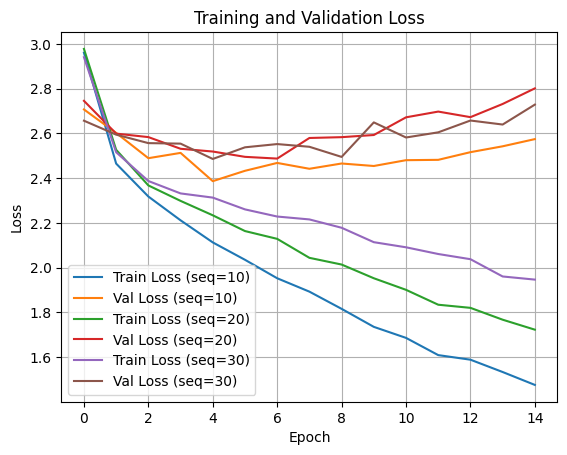

Sequence Length: 10
Training Time: 7.02 seconds
Model Size: 276268 parameters
Final Validation Accuracy: 36.55%

Sequence Length: 20
Training Time: 7.37 seconds
Model Size: 276268 parameters
Final Validation Accuracy: 29.54%

Sequence Length: 30
Training Time: 7.15 seconds
Model Size: 276268 parameters
Final Validation Accuracy: 26.27%



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the sequence
text = (
    "Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. "
    "This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. "
    "At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. "
    "These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. "
    "One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. "
    "RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. "
    "LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. "
    "Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. "
    "During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. "
    "Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. "
    "This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. "
    "In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. "
    "Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology."
)

# Build vocabulary
chars = sorted(list(set(text)))
char2idx = {ch: idx for idx, ch in enumerate(chars)}
idx2char = {idx: ch for ch, idx in char2idx.items()}
vocab_size = len(chars)

# Prepare dataset
def create_sequences(text, seq_length):
    X = []
    y = []
    for i in range(len(text) - seq_length):
        seq = text[i:i + seq_length]
        label = text[i + seq_length]
        X.append([char2idx[ch] for ch in seq])
        y.append(char2idx[label])
    return np.array(X), np.array(y)

class CharDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=embed_size, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x[-1, :, :]
        x = self.fc(x)
        return x

# Training function
def train_model(seq_length):
    X, y = create_sequences(text, seq_length)
    split = int(len(X) * 0.9)
    train_dataset = CharDataset(X[:split], y[:split])
    val_dataset = CharDataset(X[split:], y[split:])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

    model = TransformerModel(vocab_size, 128, 4, 256, 2, 0.20).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(15):
        model.train()
        total_loss = 0
        correct = 0
        count = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            count += y_batch.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / count

        model.eval()
        val_loss = 0
        val_correct = 0
        val_count = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_correct += (preds == y_batch).sum().item()
                val_count += y_batch.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_count

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Seq Length: {seq_length} | Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    duration = time.time() - start_time

    return {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history,
        'duration': duration,
        'model_size': sum(p.numel() for p in model.parameters() if p.requires_grad)
    }

results = {}
for seq_len in [10, 20, 30]:
    results[seq_len] = train_model(seq_len)

# Plot losses
for seq_len in results:
    plt.plot(results[seq_len]['train_loss'], label=f'Train Loss (seq={seq_len})')
    plt.plot(results[seq_len]['val_loss'], label=f'Val Loss (seq={seq_len})')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Display training times after plotting
for seq_len in results:
    print(f"Sequence Length: {seq_len}")
    print(f"Training Time: {results[seq_len]['duration']:.2f} seconds")
    print(f"Model Size: {results[seq_len]['model_size']} parameters")
    print(f"Final Validation Accuracy: {results[seq_len]['val_acc'][-1]*100:.2f}%\n")

Problem 2

Using device: cuda


c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Seq 20 | Layers 1 | Heads 2 | Epoch 1 | Train Loss 2.4604 | Val Loss 2.3863 | Train Acc 0.2840 | Val Acc 0.2937
Seq 20 | Layers 1 | Heads 2 | Epoch 2 | Train Loss 2.3567 | Val Loss 2.3729 | Train Acc 0.3034 | Val Acc 0.3006
Seq 20 | Layers 1 | Heads 2 | Epoch 3 | Train Loss 2.3318 | Val Loss 2.3685 | Train Acc 0.3094 | Val Acc 0.3034
Seq 20 | Layers 1 | Heads 2 | Epoch 4 | Train Loss 2.3173 | Val Loss 2.3546 | Train Acc 0.3135 | Val Acc 0.3058
Seq 20 | Layers 1 | Heads 2 | Epoch 5 | Train Loss 2.3070 | Val Loss 2.3483 | Train Acc 0.3162 | Val Acc 0.3066
Seq 20 | Layers 1 | Heads 2 | Epoch 6 | Train Loss 2.2983 | Val Loss 2.3412 | Train Acc 0.3181 | Val Acc 0.3083
Seq 20 | Layers 1 | Heads 2 | Epoch 7 | Train Loss 2.2923 | Val Loss 2.3373 | Train Acc 0.3194 | Val Acc 0.3118
Seq 20 | Layers 1 | Heads 2 | Epoch 8 | Train Loss 2.2885 | Val Loss 2.3260 | Train Acc 0.3206 | Val Acc 0.3137
Seq 20 | Layers 1 | Heads 2 | Epoch 9 | Train Loss 2.2844 | Val Loss 2.3379 | Train Acc 0.3218 | Val Acc

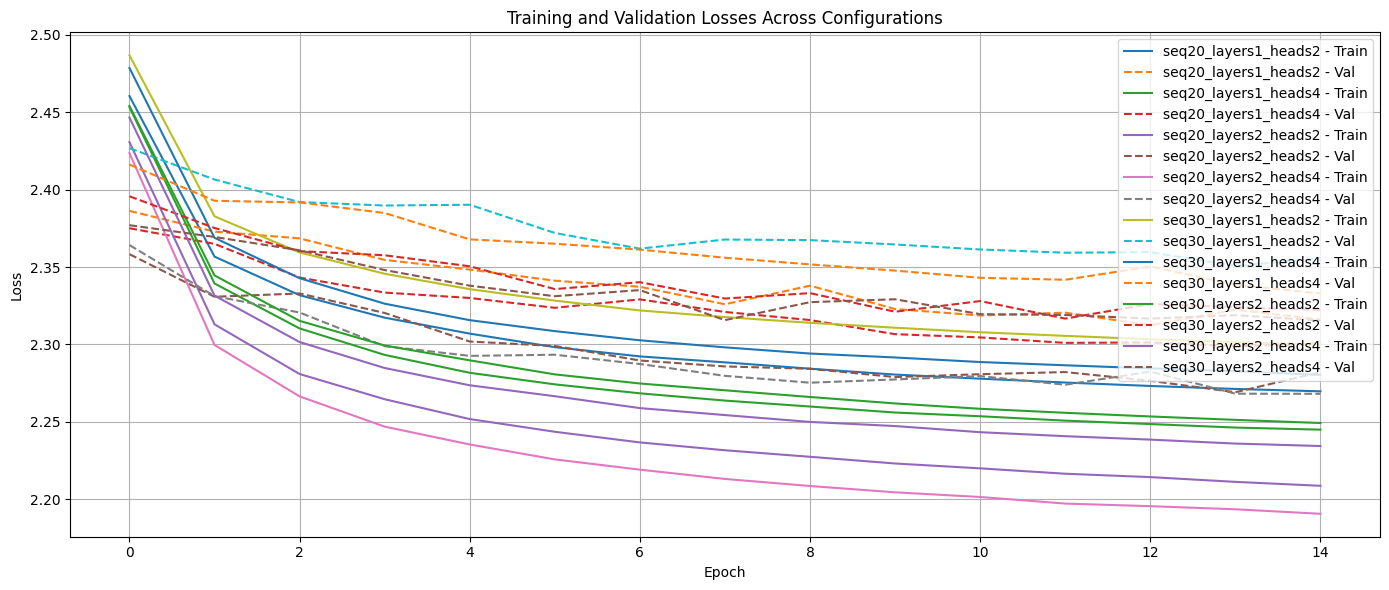


Final Results (Validation Accuracy & Training Time):
seq20_layers1_heads2: Final Val Acc = 0.3155, Time = 422.18 seconds
seq20_layers1_heads4: Final Val Acc = 0.3250, Time = 479.26 seconds
seq20_layers2_heads2: Final Val Acc = 0.3285, Time = 594.26 seconds
seq20_layers2_heads4: Final Val Acc = 0.3363, Time = 646.11 seconds
seq30_layers1_heads2: Final Val Acc = 0.3068, Time = 514.72 seconds
seq30_layers1_heads4: Final Val Acc = 0.3119, Time = 437.06 seconds
seq30_layers2_heads2: Final Val Acc = 0.3155, Time = 606.94 seconds
seq30_layers2_heads4: Final Val Acc = 0.3195, Time = 644.22 seconds


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests
import time
import matplotlib.pyplot as plt

# Setup
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
data = requests.get(url).text
chars = sorted(list(set(data)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])

def create_dataset(text, seq_length):
    X, y = [], []
    for i in range(len(text) - seq_length):
        X.append(encode(text[i:i+seq_length]))
        y.append(stoi[text[i+seq_length]])
    return np.array(X), np.array(y)

class CharDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, hidden_dim, num_layers, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        encoder_layer = nn.TransformerEncoderLayer(embed_size, num_heads, hidden_dim, dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(embed_size, vocab_size)
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = self.fc(x[-1])
        return x

def train_transformer(seq_len, num_layers, num_heads, hidden_dim=256, epochs=15, batch_size=1024):
    X, y = create_dataset(data, seq_len)
    split = int(0.9 * len(X))
    train_dataset = CharDataset(X[:split], y[:split])
    val_dataset = CharDataset(X[split:], y[split:])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, drop_last=True)

    model = TransformerModel(vocab_size, 128, num_heads, hidden_dim, num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    start = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
                pred = output.argmax(dim=1)
                val_correct += (pred == y_batch).sum().item()
                val_total += y_batch.size(0)
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Seq {seq_len} | Layers {num_layers} | Heads {num_heads} | Epoch {epoch+1} "
              f"| Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} "
              f"| Train Acc {train_acc:.4f} | Val Acc {val_acc:.4f}")

    training_time = time.time() - start
    model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)

    dummy_input = torch.randint(0, vocab_size, (1, seq_len)).to(device)
    start_inf = time.time()
    with torch.no_grad():
        _ = model(dummy_input)
    inference_time = time.time() - start_inf

    sample_input = torch.tensor([encode(data[:seq_len])], dtype=torch.long).to(device)
    with torch.no_grad():
        output = model(sample_input).argmax(dim=1).item()
    predicted_char = itos[output]

    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies,
        'train_time': training_time,
        'inference_time': inference_time,
        'model_size': model_size,
        'output': predicted_char
    }

# Define new configurations: 2 seq_lens x 2 layers x 2 heads = 8 total
configs = [(seq, layers, heads) for seq in [20, 30] for layers in [1, 2] for heads in [2, 4]]

# Run training
results = {}
for seq_len, num_layers, num_heads in configs:
    key = f"seq{seq_len}_layers{num_layers}_heads{num_heads}"
    results[key] = train_transformer(seq_len, num_layers, num_heads)

# Plot training and validation losses
plt.figure(figsize=(14, 6))
for key, result in results.items():
    plt.plot(result['train_loss'], label=f'{key} - Train')
    plt.plot(result['val_loss'], label=f'{key} - Val', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Across Configurations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print final results
print("\nFinal Results (Validation Accuracy & Training Time):")
for key, result in results.items():
    print(f"{key}: Final Val Acc = {result['val_acc'][-1]:.4f}, Time = {result['train_time']:.2f} seconds")


Problem 3

Using device: cuda
L1_H2 | Epoch 01 | Train Loss: 5.1369 | Val Loss: 4.4290 | Val Acc: 0.1736
L1_H2 | Epoch 02 | Train Loss: 4.4283 | Val Loss: 4.0239 | Val Acc: 0.3103
L1_H2 | Epoch 03 | Train Loss: 4.0664 | Val Loss: 3.5355 | Val Acc: 0.3257
L1_H2 | Epoch 04 | Train Loss: 3.7268 | Val Loss: 3.2239 | Val Acc: 0.3610
L1_H2 | Epoch 05 | Train Loss: 3.4292 | Val Loss: 2.8752 | Val Acc: 0.3978
L1_H2 | Epoch 06 | Train Loss: 3.2315 | Val Loss: 2.5852 | Val Acc: 0.4147
L1_H2 | Epoch 07 | Train Loss: 2.9168 | Val Loss: 2.3206 | Val Acc: 0.4578
L1_H2 | Epoch 08 | Train Loss: 2.7974 | Val Loss: 2.1034 | Val Acc: 0.4885
L1_H2 | Epoch 09 | Train Loss: 2.5910 | Val Loss: 1.8638 | Val Acc: 0.5576
L1_H2 | Epoch 10 | Train Loss: 2.3497 | Val Loss: 1.7461 | Val Acc: 0.5653
L1_H2 | Epoch 11 | Train Loss: 2.2439 | Val Loss: 1.5362 | Val Acc: 0.6421
L1_H2 | Epoch 12 | Train Loss: 2.1149 | Val Loss: 1.3825 | Val Acc: 0.6897
L1_H2 | Epoch 13 | Train Loss: 1.9818 | Val Loss: 1.2885 | Val Acc: 0.7127
L1_H2 

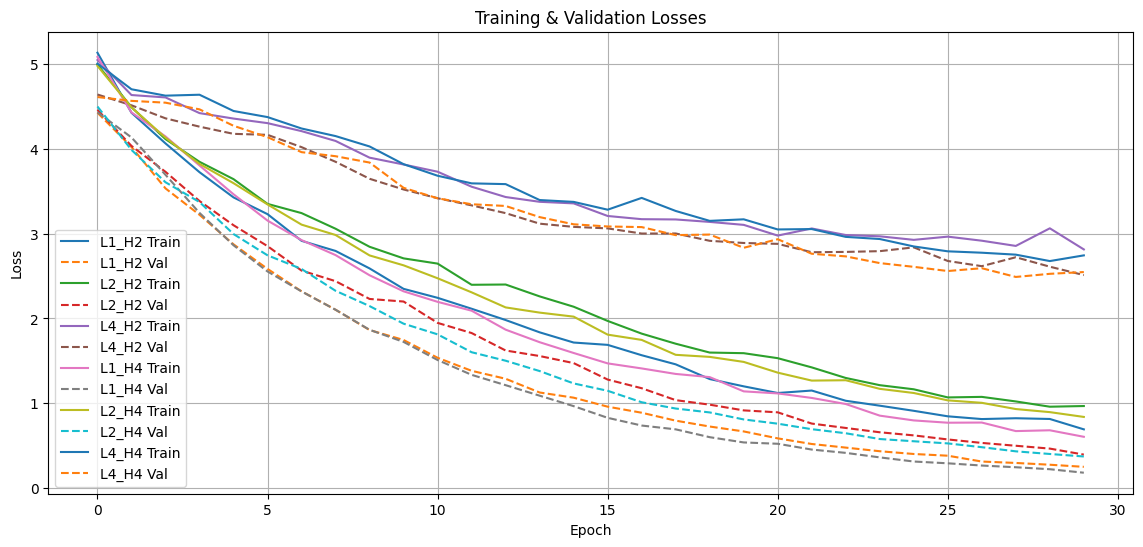


Final Results:
L1_H2: Final Val Acc = 0.9785, Time = 12.64s
L2_H2: Final Val Acc = 0.9416, Time = 19.12s
L4_H2: Final Val Acc = 0.3733, Time = 29.11s
L1_H4: Final Val Acc = 0.9877, Time = 10.83s
L2_H4: Final Val Acc = 0.9339, Time = 17.72s
L4_H4: Final Val Acc = 0.3671, Time = 28.71s

Sample Translations:

Model: L1_H2
  [Seen] He is hungry → il a faim
  [Seen] We travel by train → nous voyageons en train
  [Seen] She dances gracefully → elle danse avec grâce
  [Seen] The sun sets in the evening → le soleil se couche le soir
  [Unseen] She reads in the library → elle court dans le parc
  [Unseen] The car is fast → le soleil se couche le soir
  [Unseen] Birds fly in the sky → les oiseaux gazouillent le matin
  [Unseen] I write code at night → il peint des lunettes

Model: L2_H2
  [Seen] He is hungry → il répare la voiture
  [Seen] We travel by train → nous regardons un film commence à nos grands-parents
  [Seen] She dances gracefully → elle danse à l'école
  [Seen] The sun sets in the 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare dataset
english_to_french = [
("I am cold", "J'ai froid"),
("You are tired", "Tu es fatigué"),
("He is hungry", "Il a faim"),
("She is happy", "Elle est heureuse"),
("We are friends", "Nous sommes amis"),
("They are students", "Ils sont étudiants"),
("The cat is sleeping", "Le chat dort"),
("The sun is shining", "Le soleil brille"),
("We love music", "Nous aimons la musique"),
("She speaks French fluently", "Elle parle français couramment"),
("He enjoys reading books", "Il aime lire des livres"),
("They play soccer every weekend", "Ils jouent au football chaque week-end"),
("The movie starts at 7 PM", "Le film commence à 19 heures"),
("She wears a red dress", "Elle porte une robe rouge"),
("We cook dinner together", "Nous cuisinons le dîner ensemble"),
("He drives a blue car", "Il conduit une voiture bleue"),
("They visit museums often", "Ils visitent souvent des musées"),
("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),
("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),
("We watch movies on Fridays", "Nous regardons des films le vendredi"),
("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),
("They travel around the world", "Ils voyagent autour du monde"),
("The book is on the table", "Le livre est sur la table"),
("She dances gracefully", "Elle danse avec grâce"),
("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),
("He works hard every day", "Il travaille dur tous les jours"),
("They speak different languages", "Ils parlent différentes langues"),
("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),
("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),
("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),
("The dog barks loudly", "Le chien aboie bruyamment"),
("He sings beautifully", "Il chante magnifiquement"),
("They swim in the pool", "Ils nagent dans la piscine"),
("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),
("She teaches English at school", "Elle enseigne l'anglais à l'école"),
("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),
("He paints landscapes", "Il peint des paysages"),
("They laugh at the joke", "Ils rient de la blague"),
("The clock ticks loudly", "L'horloge tic-tac bruyamment"),
("She runs in the park", "Elle court dans le parc"),
("We travel by train", "Nous voyageons en train"),
("He writes a letter", "Il écrit une lettre"),
("They read books at the library", "Ils lisent des livres à la bibliothèque"),
("The baby cries", "Le bébé pleure"),
("She studies hard for exams", "Elle étudie dur pour les examens"),
("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),
("He fixes the car", "Il répare la voiture"),
("They drink coffee in the morning", "Ils boivent du café le matin"),
("The sun sets in the evening", "Le soleil se couche le soir"),
("She dances at the party", "Elle danse à la fête"),
("We play music at the concert", "Nous jouons de la musique au concert"),
("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),
("They study French grammar", "Ils étudient la grammaire française"),
("The rain falls gently", "La pluie tombe doucement"),
("She sings a song", "Elle chante une chanson"),
("We watch a movie together", "Nous regardons un film ensemble"),
("He sleeps deeply", "Il dort profondément"),
("They travel to Paris", "Ils voyagent à Paris"),
("The children play in the park", "Les enfants jouent dans le parc"),
("She walks along the beach", "Elle se promène le long de la plage"),
("We talk on the phone", "Nous parlons au téléphone"),
("He waits for the bus", "Il attend le bus"),
("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),
("The stars twinkle at night", "Les étoiles scintillent la nuit"),
("She dreams of flying", "Elle rêve de voler"),
("We work in the office", "Nous travaillons au bureau"),
("He studies history", "Il étudie l'histoire"),
("They listen to the radio", "Ils écoutent la radio"),
("The wind blows gently", "Le vent souffle doucement"),
("She swims in the ocean", "Elle nage dans l'océan"),
("We dance at the wedding", "Nous dansons au mariage"),
("He climbs the mountain", "Il gravit la montagne"),
("They hike in the forest", "Ils font de la randonnée dans la forêt"),
("The cat meows loudly", "Le chat miaule bruyamment"),
("She paints a picture", "Elle peint un tableau"),
("We build a sandcastle", "Nous construisons un château de sable"),
("He sings in the choir", "Il chante dans le chœur"),
("They ride bicycles", "Ils font du vélo"),
("The coffee is hot", "Le café est chaud"),
("She wears glasses", "Elle porte des lunettes"),
("We visit our grandparents", "Nous rendons visite à nos grands-parents"),
("He plays the guitar", "Il joue de la guitare"),
("They go shopping", "Ils font du shopping"),
("The teacher explains the lesson", "Le professeur explique la leçon"),
("She takes the train to work", "Elle prend le train pour aller au travail"),
("We bake cookies", "Nous faisons des biscuits"),
("He washes his hands", "Il se lave les mains"),
("They enjoy the sunset", "Ils apprécient le coucher du soleil"),
("The river flows calmly", "La rivière coule calmement"),
("She feeds the cat", "Elle nourrit le chat"),
("We visit the museum", "Nous visitons le musée"),
("He fixes his bicycle", "Il répare son vélo"),
("They paint the walls", "Ils peignent les murs"),
("The baby sleeps peacefully", "Le bébé dort paisiblement"),
("She ties her shoelaces", "Elle attache ses lacets"),
("We climb the stairs", "Nous montons les escaliers"),
("He shaves in the morning", "Il se rase le matin"),
("They set the table", "Ils mettent la table"),
("The airplane takes off", "L'avion décolle"),
("She waters the plants", "Elle arrose les plantes"),
("We practice yoga", "Nous pratiquons le yoga"),
("He turns off the light", "Il éteint la lumière"),
("They play video games", "Ils jouent aux jeux vidéo"),
("The soup smells delicious", "La soupe sent délicieusement bon"),
("She locks the door", "Elle ferme la porte à clé"),
("We enjoy a picnic", "Nous profitons d'un pique-nique"),
("He checks his email", "Il vérifie ses emails"),
("They go to the gym", "Ils vont à la salle de sport"),
("The moon shines brightly", "La lune brille intensément"),
("She catches the bus", "Elle attrape le bus"),
("We greet our neighbors", "Nous saluons nos voisins"),
("He combs his hair", "Il se peigne les cheveux"),
("They wave goodbye", "Ils font un signe d'adieu")
]


# Build vocab
def build_vocab(sentences):
    vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    for sentence in sentences:
        for token in sentence.lower().split():
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab

eng_sentences = [pair[0] for pair in english_to_french]
fra_sentences = [pair[1] for pair in english_to_french]
src_vocab = build_vocab(eng_sentences)
tgt_vocab = build_vocab(fra_sentences)
inv_tgt_vocab = {i: w for w, i in tgt_vocab.items()}

# Tokenizer
def tokenize(sentence, vocab):
    return [vocab["<sos>"]] + [vocab.get(word, vocab["<unk>"]) for word in sentence.lower().split()] + [vocab["<eos>"]]

class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        src_ids = tokenize(src, src_vocab)
        tgt_ids = tokenize(tgt, tgt_vocab)
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_padded = nn.utils.rnn.pad_sequence(src_batch, padding_value=0)
    tgt_padded = nn.utils.rnn.pad_sequence(tgt_batch, padding_value=0)
    return src_padded, tgt_padded

# Transformer Encoder-Decoder with Dropout, L2, BatchNorm
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_layers, num_heads, src_vocab_size, tgt_vocab_size, embed_dim=128, ff_dim=256):
        super().__init__()
        self.src_embed = nn.Embedding(src_vocab_size, embed_dim)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, embed_dim)
        self.src_bn = nn.BatchNorm1d(embed_dim)
        self.tgt_bn = nn.BatchNorm1d(embed_dim)
        self.dropout = nn.Dropout(0.2)

        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_dim,
            dropout=0.2,
            batch_first=False
        )

        self.fc_out = nn.Linear(embed_dim, tgt_vocab_size)
        self.embed_dim = embed_dim

    def forward(self, src, tgt):
        src_mask = self.transformer.generate_square_subsequent_mask(src.size(0)).to(device)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(0)).to(device)

        src_emb = self.dropout(self.src_embed(src) * (self.embed_dim ** 0.5))
        tgt_emb = self.dropout(self.tgt_embed(tgt) * (self.embed_dim ** 0.5))

        # BatchNorm expects shape [B, C, T] -> transpose for correct dim usage
        src_emb = self.src_bn(src_emb.permute(1, 2, 0)).permute(2, 0, 1)
        tgt_emb = self.tgt_bn(tgt_emb.permute(1, 2, 0)).permute(2, 0, 1)

        output = self.transformer(src_emb, tgt_emb, src_mask=src_mask, tgt_mask=tgt_mask)
        return self.fc_out(output)

# Training Function
def train_model(config_id, num_layers, num_heads, epochs=30):
    model = Seq2SeqTransformer(num_layers, num_heads, len(src_vocab), len(tgt_vocab)).to(device)
    dataset = TranslationDataset(english_to_french)
    loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 reg
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    train_loss, val_loss, val_acc = [], [], []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:-1, :]
            tgt_output = tgt[1:, :]

            optimizer.zero_grad()
            logits = model(src, tgt_input)
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss.append(total_loss / len(loader))

        # Evaluation
        model.eval()
        correct, total = 0, 0
        val_total_loss = 0
        with torch.no_grad():
            for src, tgt in loader:
                src, tgt = src.to(device), tgt.to(device)
                tgt_input = tgt[:-1, :]
                tgt_output = tgt[1:, :]
                logits = model(src, tgt_input)
                loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
                val_total_loss += loss.item()
                preds = logits.argmax(dim=-1)
                mask = tgt_output != 0
                correct += (preds == tgt_output)[mask].sum().item()
                total += mask.sum().item()
        val_loss.append(val_total_loss / len(loader))
        val_acc.append(correct / total)

        print(f"{config_id} | Epoch {epoch+1:02d} | Train Loss: {train_loss[-1]:.4f} | "
              f"Val Loss: {val_loss[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}")

    training_time = time.time() - start_time
    return model, train_loss, val_loss, val_acc, training_time

# Run all 6 configs
configs = [(1,2), (2,2), (4,2), (1,4), (2,4), (4,4)]
results = {}

for layers, heads in configs:
    config_id = f"L{layers}_H{heads}"
    model, train_l, val_l, val_a, t_time = train_model(config_id, layers, heads)
    results[config_id] = {
        'train_loss': train_l,
        'val_loss': val_l,
        'val_acc': val_a,
        'time': t_time,
        'model': model
    }

# Plotting losses
plt.figure(figsize=(14, 6))
for k, v in results.items():
    plt.plot(v['train_loss'], label=f"{k} Train")
    plt.plot(v['val_loss'], linestyle='--', label=f"{k} Val")
plt.title("Training & Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Final Accuracies & Times
print("\nFinal Results:")
for k, v in results.items():
    print(f"{k}: Final Val Acc = {v['val_acc'][-1]:.4f}, Time = {v['time']:.2f}s")

# Translate sentences
def translate_sentence(model, sentence):
    model.eval()
    src = torch.tensor(tokenize(sentence, src_vocab)).unsqueeze(1).to(device)
    tgt_input = torch.tensor([tgt_vocab["<sos>"]], dtype=torch.long).unsqueeze(1).to(device)
    for _ in range(20):
        out = model(src, tgt_input)
        next_token = out.argmax(dim=-1)[-1, 0].item()
        tgt_input = torch.cat([tgt_input, torch.tensor([[next_token]], device=device)], dim=0)
        if next_token == tgt_vocab["<eos>"]:
            break
    translated = [inv_tgt_vocab[idx.item()] for idx in tgt_input[1:-1, 0]]
    return ' '.join(translated)

# Mixed evaluation
seen_sentences = [
    "He is hungry", "We travel by train", "She dances gracefully", "The sun sets in the evening"
]
unseen_sentences = [
    "She reads in the library", "The car is fast", "Birds fly in the sky", "I write code at night"
]
labeled_sentences = [("Seen", s) for s in seen_sentences] + [("Unseen", s) for s in unseen_sentences]

print("\nSample Translations:")
for k in results:
    print(f"\nModel: {k}")
    for label, sentence in labeled_sentences:
        translation = translate_sentence(results[k]['model'], sentence)
        print(f"  [{label}] {sentence} → {translation}")


Using device: cuda
L1_H2 | Epoch 01 | Train Loss: 4.8506 | Val Loss: 4.1992 | Val Acc: 0.2323
L1_H2 | Epoch 02 | Train Loss: 4.1477 | Val Loss: 3.6989 | Val Acc: 0.3180
L1_H2 | Epoch 03 | Train Loss: 3.8439 | Val Loss: 3.2615 | Val Acc: 0.3526
L1_H2 | Epoch 04 | Train Loss: 3.4445 | Val Loss: 2.9695 | Val Acc: 0.4316
L1_H2 | Epoch 05 | Train Loss: 3.1635 | Val Loss: 2.7051 | Val Acc: 0.4432
L1_H2 | Epoch 06 | Train Loss: 2.9924 | Val Loss: 2.3945 | Val Acc: 0.4712
L1_H2 | Epoch 07 | Train Loss: 2.6924 | Val Loss: 2.1358 | Val Acc: 0.4926
L1_H2 | Epoch 08 | Train Loss: 2.5104 | Val Loss: 1.9178 | Val Acc: 0.5404
L1_H2 | Epoch 09 | Train Loss: 2.4007 | Val Loss: 1.7690 | Val Acc: 0.5931
L1_H2 | Epoch 10 | Train Loss: 2.2402 | Val Loss: 1.6030 | Val Acc: 0.6277
L1_H2 | Epoch 11 | Train Loss: 2.1110 | Val Loss: 1.4745 | Val Acc: 0.6540
L1_H2 | Epoch 12 | Train Loss: 2.0095 | Val Loss: 1.3315 | Val Acc: 0.7018
L1_H2 | Epoch 13 | Train Loss: 1.8568 | Val Loss: 1.1870 | Val Acc: 0.7595
L1_H2 

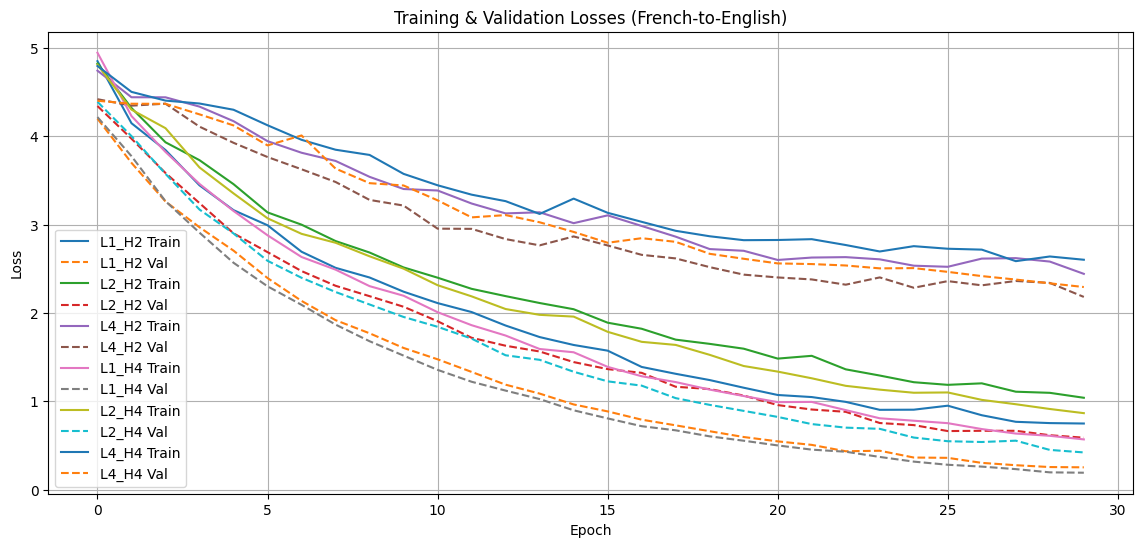


Final Results:
L1_H2: Final Val Acc = 0.9835, Time = 12.79s
L2_H2: Final Val Acc = 0.8501, Time = 17.17s
L4_H2: Final Val Acc = 0.4629, Time = 28.47s
L1_H4: Final Val Acc = 0.9934, Time = 11.78s
L2_H4: Final Val Acc = 0.9209, Time = 19.29s
L4_H4: Final Val Acc = 0.4003, Time = 33.63s

Sample Translations (French-to-English):

Model: L1_H2
  [Seen] Il a faim → he is hungry
  [Seen] Nous voyageons en train → we travel by train
  [Seen] Elle danse avec grâce → she dances gracefully
  [Seen] Le soleil se couche le soir → the sun sets in the evening
  [Unseen] Elle lit dans la bibliothèque → she wears a picture
  [Unseen] La voiture est rapide → he plays the guitar
  [Unseen] Les oiseaux volent dans le ciel → the children play in the park
  [Unseen] Je programme la nuit → the restaurant serves delicious food

Model: L2_H2
  [Seen] Il a faim → he cooks dinner for his family
  [Seen] Nous voyageons en train → we watch a movie together
  [Seen] Elle danse avec grâce → she dances gracefully
  

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare dataset (original English-to-French pairs)
english_to_french = [
    ("I am cold", "J'ai froid"),
    ("You are tired", "Tu es fatigué"),
    ("He is hungry", "Il a faim"),
    ("She is happy", "Elle est heureuse"),
    ("We are friends", "Nous sommes amis"),
    ("They are students", "Ils sont étudiants"),
    ("The cat is sleeping", "Le chat dort"),
    ("The sun is shining", "Le soleil brille"),
    ("We love music", "Nous aimons la musique"),
    ("She speaks French fluently", "Elle parle français couramment"),
    ("He enjoys reading books", "Il aime lire des livres"),
    ("They play soccer every weekend", "Ils jouent au football chaque week-end"),
    ("The movie starts at 7 PM", "Le film commence à 19 heures"),
    ("She wears a red dress", "Elle porte une robe rouge"),
    ("We cook dinner together", "Nous cuisinons le dîner ensemble"),
    ("He drives a blue car", "Il conduit une voiture bleue"),
    ("They visit museums often", "Ils visitent souvent des musées"),
    ("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),
    ("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),
    ("We watch movies on Fridays", "Nous regardons des films le vendredi"),
    ("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),
    ("They travel around the world", "Ils voyagent autour du monde"),
    ("The book is on the table", "Le livre est sur la table"),
    ("She dances gracefully", "Elle danse avec grâce"),
    ("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),
    ("He works hard every day", "Il travaille dur tous les jours"),
    ("They speak different languages", "Ils parlent différentes langues"),
    ("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),
    ("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),
    ("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),
    ("The dog barks loudly", "Le chien aboie bruyamment"),
    ("He sings beautifully", "Il chante magnifiquement"),
    ("They swim in the pool", "Ils nagent dans la piscine"),
    ("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),
    ("She teaches English at school", "Elle enseigne l'anglais à l'école"),
    ("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),
    ("He paints landscapes", "Il peint des paysages"),
    ("They laugh at the joke", "Ils rient de la blague"),
    ("The clock ticks loudly", "L'horloge tic-tac bruyamment"),
    ("She runs in the park", "Elle court dans le parc"),
    ("We travel by train", "Nous voyageons en train"),
    ("He writes a letter", "Il écrit une lettre"),
    ("They read books at the library", "Ils lisent des livres à la bibliothèque"),
    ("The baby cries", "Le bébé pleure"),
    ("She studies hard for exams", "Elle étudie dur pour les examens"),
    ("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),
    ("He fixes the car", "Il répare la voiture"),
    ("They drink coffee in the morning", "Ils boivent du café le matin"),
    ("The sun sets in the evening", "Le soleil se couche le soir"),
    ("She dances at the party", "Elle danse à la fête"),
    ("We play music at the concert", "Nous jouons de la musique au concert"),
    ("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),
    ("They study French grammar", "Ils étudient la grammaire française"),
    ("The rain falls gently", "La pluie tombe doucement"),
    ("She sings a song", "Elle chante une chanson"),
    ("We watch a movie together", "Nous regardons un film ensemble"),
    ("He sleeps deeply", "Il dort profondément"),
    ("They travel to Paris", "Ils voyagent à Paris"),
    ("The children play in the park", "Les enfants jouent dans le parc"),
    ("She walks along the beach", "Elle se promène le long de la plage"),
    ("We talk on the phone", "Nous parlons au téléphone"),
    ("He waits for the bus", "Il attend le bus"),
    ("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),
    ("The stars twinkle at night", "Les étoiles scintillent la nuit"),
    ("She dreams of flying", "Elle rêve de voler"),
    ("We work in the office", "Nous travaillons au bureau"),
    ("He studies history", "Il étudie l'histoire"),
    ("They listen to the radio", "Ils écoutent la radio"),
    ("The wind blows gently", "Le vent souffle doucement"),
    ("She swims in the ocean", "Elle nage dans l'océan"),
    ("We dance at the wedding", "Nous dansons au mariage"),
    ("He climbs the mountain", "Il gravit la montagne"),
    ("They hike in the forest", "Ils font de la randonnée dans la forêt"),
    ("The cat meows loudly", "Le chat miaule bruyamment"),
    ("She paints a picture", "Elle peint un tableau"),
    ("We build a sandcastle", "Nous construisons un château de sable"),
    ("He sings in the choir", "Il chante dans le chœur"),
    ("They ride bicycles", "Ils font du vélo"),
    ("The coffee is hot", "Le café est chaud"),
    ("She wears glasses", "Elle porte des lunettes"),
    ("We visit our grandparents", "Nous rendons visite à nos grands-parents"),
    ("He plays the guitar", "Il joue de la guitare"),
    ("They go shopping", "Ils font du shopping"),
    ("The teacher explains the lesson", "Le professeur explique la leçon"),
    ("She takes the train to work", "Elle prend le train pour aller au travail"),
    ("We bake cookies", "Nous faisons des biscuits"),
    ("He washes his hands", "Il se lave les mains"),
    ("They enjoy the sunset", "Ils apprécient le coucher du soleil"),
    ("The river flows calmly", "La rivière coule calmement"),
    ("She feeds the cat", "Elle nourrit le chat"),
    ("We visit the museum", "Nous visitons le musée"),
    ("He fixes his bicycle", "Il répare son vélo"),
    ("They paint the walls", "Ils peignent les murs"),
    ("The baby sleeps peacefully", "Le bébé dort paisiblement"),
    ("She ties her shoelaces", "Elle attache ses lacets"),
    ("We climb the stairs", "Nous montons les escaliers"),
    ("He shaves in the morning", "Il se rase le matin"),
    ("They set the table", "Ils mettent la table"),
    ("The airplane takes off", "L'avion décolle"),
    ("She waters the plants", "Elle arrose les plantes"),
    ("We practice yoga", "Nous pratiquons le yoga"),
    ("He turns off the light", "Il éteint la lumière"),
    ("They play video games", "Ils jouent aux jeux vidéo"),
    ("The soup smells delicious", "La soupe sent délicieusement bon"),
    ("She locks the door", "Elle ferme la porte à clé"),
    ("We enjoy a picnic", "Nous profitons d'un pique-nique"),
    ("He checks his email", "Il vérifie ses emails"),
    ("They go to the gym", "Ils vont à la salle de sport"),
    ("The moon shines brightly", "La lune brille intensément"),
    ("She catches the bus", "Elle attrape le bus"),
    ("We greet our neighbors", "Nous saluons nos voisins"),
    ("He combs his hair", "Il se peigne les cheveux"),
    ("They wave goodbye", "Ils font un signe d'adieu")
]

# Create French-to-English dataset by reversing the pairs
french_to_english = [(fr, en) for en, fr in english_to_french]

# Build vocabulary for source (French) and target (English)
def build_vocab(sentences):
    vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    for sentence in sentences:
        for token in sentence.lower().split():
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab

src_sentences = [pair[0] for pair in french_to_english]  # French sentences
tgt_sentences = [pair[1] for pair in french_to_english]  # English sentences
src_vocab = build_vocab(src_sentences)
tgt_vocab = build_vocab(tgt_sentences)
inv_tgt_vocab = {i: w for w, i in tgt_vocab.items()}

# Tokenizer
def tokenize(sentence, vocab):
    return [vocab["<sos>"]] + [vocab.get(word, vocab["<unk>"]) for word in sentence.lower().split()] + [vocab["<eos>"]]

class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self): 
        return len(self.data)
    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        src_ids = tokenize(src, src_vocab)
        tgt_ids = tokenize(tgt, tgt_vocab)
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_padded = nn.utils.rnn.pad_sequence(src_batch, padding_value=0)
    tgt_padded = nn.utils.rnn.pad_sequence(tgt_batch, padding_value=0)
    return src_padded, tgt_padded

# Transformer Encoder-Decoder with Dropout (0.2), L2 regularization, and BatchNorm
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_layers, num_heads, src_vocab_size, tgt_vocab_size, embed_dim=128, ff_dim=256):
        super().__init__()
        self.src_embed = nn.Embedding(src_vocab_size, embed_dim)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, embed_dim)
        self.src_bn = nn.BatchNorm1d(embed_dim)
        self.tgt_bn = nn.BatchNorm1d(embed_dim)
        self.dropout = nn.Dropout(0.2)

        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_dim,
            dropout=0.2,
            batch_first=False
        )
        self.fc_out = nn.Linear(embed_dim, tgt_vocab_size)
        self.embed_dim = embed_dim

    def forward(self, src, tgt):
        src_mask = self.transformer.generate_square_subsequent_mask(src.size(0)).to(device)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(0)).to(device)

        src_emb = self.dropout(self.src_embed(src) * (self.embed_dim ** 0.5))
        tgt_emb = self.dropout(self.tgt_embed(tgt) * (self.embed_dim ** 0.5))

        # BatchNorm expects shape [B, C, T] -> transpose accordingly
        src_emb = self.src_bn(src_emb.permute(1, 2, 0)).permute(2, 0, 1)
        tgt_emb = self.tgt_bn(tgt_emb.permute(1, 2, 0)).permute(2, 0, 1)

        output = self.transformer(src_emb, tgt_emb, src_mask=src_mask, tgt_mask=tgt_mask)
        return self.fc_out(output)

# Training Function
def train_model(config_id, num_layers, num_heads, epochs=30):
    model = Seq2SeqTransformer(num_layers, num_heads, len(src_vocab), len(tgt_vocab)).to(device)
    dataset = TranslationDataset(french_to_english)
    loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 regularization
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    train_loss, val_loss, val_acc = [], [], []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:-1, :]
            tgt_output = tgt[1:, :]

            optimizer.zero_grad()
            logits = model(src, tgt_input)
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss.append(total_loss / len(loader))

        # Evaluation
        model.eval()
        correct, total = 0, 0
        val_total_loss = 0
        with torch.no_grad():
            for src, tgt in loader:
                src, tgt = src.to(device), tgt.to(device)
                tgt_input = tgt[:-1, :]
                tgt_output = tgt[1:, :]
                logits = model(src, tgt_input)
                loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
                val_total_loss += loss.item()
                preds = logits.argmax(dim=-1)
                mask = tgt_output != 0
                correct += (preds == tgt_output)[mask].sum().item()
                total += mask.sum().item()
        val_loss.append(val_total_loss / len(loader))
        val_acc.append(correct / total)

        print(f"{config_id} | Epoch {epoch+1:02d} | Train Loss: {train_loss[-1]:.4f} | "
              f"Val Loss: {val_loss[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}")

    training_time = time.time() - start_time
    return model, train_loss, val_loss, val_acc, training_time

# Run all 6 configurations
configs = [(1,2), (2,2), (4,2), (1,4), (2,4), (4,4)]
results = {}

for layers, heads in configs:
    config_id = f"L{layers}_H{heads}"
    model, train_l, val_l, val_a, t_time = train_model(config_id, layers, heads)
    results[config_id] = {
        'train_loss': train_l,
        'val_loss': val_l,
        'val_acc': val_a,
        'time': t_time,
        'model': model
    }

# Plot training and validation losses
plt.figure(figsize=(14, 6))
for k, v in results.items():
    plt.plot(v['train_loss'], label=f"{k} Train")
    plt.plot(v['val_loss'], linestyle='--', label=f"{k} Val")
plt.title("Training & Validation Losses (French-to-English)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Final Accuracies & Training Times
print("\nFinal Results:")
for k, v in results.items():
    print(f"{k}: Final Val Acc = {v['val_acc'][-1]:.4f}, Time = {v['time']:.2f}s")

# Translation Function: Translate a French sentence to English
def translate_sentence(model, sentence):
    model.eval()
    src = torch.tensor(tokenize(sentence, src_vocab)).unsqueeze(1).to(device)
    tgt_input = torch.tensor([tgt_vocab["<sos>"]], dtype=torch.long).unsqueeze(1).to(device)
    for _ in range(20):
        out = model(src, tgt_input)
        next_token = out.argmax(dim=-1)[-1, 0].item()
        tgt_input = torch.cat([tgt_input, torch.tensor([[next_token]], device=device)], dim=0)
        if next_token == tgt_vocab["<eos>"]:
            break
    translated = [inv_tgt_vocab[idx.item()] for idx in tgt_input[1:-1, 0]]
    return ' '.join(translated)

# Define test sentences: half seen, half unseen
seen_sentences = [
    "Il a faim", "Nous voyageons en train", "Elle danse avec grâce", "Le soleil se couche le soir"
]
unseen_sentences = [
    "Elle lit dans la bibliothèque", "La voiture est rapide", "Les oiseaux volent dans le ciel", "Je programme la nuit"
]
labeled_sentences = [("Seen", s) for s in seen_sentences] + [("Unseen", s) for s in unseen_sentences]

print("\nSample Translations (French-to-English):")
for k in results:
    print(f"\nModel: {k}")
    for label, sentence in labeled_sentences:
        translation = translate_sentence(results[k]['model'], sentence)
        print(f"  [{label}] {sentence} → {translation}")
